In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
from scipy.integrate import quad
from math import *
from astropy.io import fits
import glob
import pylab 
from numpy.linalg import inv
import pandas
from iminuit import Minuit, describe

In [2]:
# Physical constants
clight = 299792.458
H0 = 0.00007324 # Riess et al. 2016: H0 = 73.24 ± 1.74 km s−1 Mpc−1

# Baseline parameters from Ancillary_G10.FITRES
Npar = 5
omgM0 = 0.298     # = 0.298 +- 0.022
M_b0 = -19.3
alpha0 = 0.15424  #  alpha0         =    0.15424 +-  0.00553   
beta0 = 3.02371   #  beta0          =    3.02371 +-  0.06431   
gamma0 = 0.05271  #  gamma0         =    0.05271 +-  0.00917 
m_step = 10.13
tau = 0.001

In [3]:
# Comoving radial coordinate (c not included) corresponding to redshift z = c int_0^z dz/H(z)
# in LambdaCDM flat model
def intfun(z, omgM):
    return 1/sqrt(omgM*(1 + z)**3 + (1 - omgM))

In [4]:
# Luminosity Distance function
def fitfundL(zcmb, omgM):
    mu = []
    for i in range (len(zcmb)): 
        zz = zcmb[i]
        mu.append(dL_z(zz, zz, omgM)) 
    return mu 

In [5]:
# Luminosity Distance corresponding to a redshift z
def dL_z(zcmb, zhel, omgM):
    mu_zz = 5*log10((1 + zhel)*clight*(quad(intfun, 0, zcmb, args=(omgM))[0] / (10*H0)))
    return mu_zz

In [6]:
# Distance modulus for the observational data, delta_b calculated from delta_{mb,x1,c}
def muexp(SNdata, M_b, alpha, beta, gamma):
    mu=[]
    for i in range(len(SNdata['mB'])):
        delta_M = gamma / (1 + np.exp(-(SNdata['HOST_LOGMASS'][i]-m_step)/tau))
        delta_b = SNdata['biasCor_mB'][i] - beta*SNdata['biasCor_c'][i] + alpha*SNdata['biasCor_x1'][i]
        mu.append(SNdata['mB'][i] - M_b + alpha*SNdata['x1'][i] - beta*SNdata['c'][i] + delta_M - delta_b)
    return mu

In [7]:
# Uncertainty on distance modulus for an observational data ???
def dmuexp(SNdata, alpha, beta):
    dmu=[]
    for i in range(len(SNdata['mB'])):
        dmu.append(sqrt(SNdata['mBERR'][i]**2+(alpha*SNdata['x1ERR'][i])**2+(beta*SNdata['cERR'][i])**2))
    return dmu

In [10]:
def outliers(data_name):
    # Read LCs parameters for outlier supernovae
    filename_outliers = '../data/FITOPT000.FITRES'
    data = pandas.read_csv(filename_outliers, comment='#', skiprows=11, header=0, delimiter=r"\s+")

    data.CID.duplicated().sum()
    SNoutliers = data[data.duplicated(subset=['CID'], keep=False)]

    SNoutliers['wt_mb'] = 1./SNoutliers['mBERR']**2
    SNoutliers['wt_x1'] = 1./SNoutliers['x1ERR']**2
    SNoutliers['wt_c'] = 1./SNoutliers['cERR']**2

### weighted mean

    grouped = SNoutliers.groupby(['CID'], as_index=False)

    def wavg_mb(group):
        d = group['mB']
        w = group['wt_mb']
        return (d * w).sum() / w.sum()
    
    def wavg_x1(group):
        d = group['x1']
        w = group['wt_x1']
        return (d * w).sum() / w.sum()
    
    def wavg_c(group):
        d = group['c']
        w = group['wt_c']
        return (d * w).sum() / w.sum()
    
    def wavg_mb_er(group):
        d = group['mB']
        w = group['wt_mb']
        err_w = np.sqrt(1 / w.sum())
#         err_w = ((d - mean_w)**2 * w).sum() / w.sum()
        return err_w

    def wavg_x1_er(group):
        d = group['x1']
        w = group['wt_x1']
        err_w = np.sqrt(1 / w.sum())
#         err_w = ((d - mean_w)**2 * w).sum() / w.sum()
        return err_w

    def wavg_c_er(group):
        d = group['c']
        w = group['wt_c']
        err_w = np.sqrt(1 / w.sum())
#         err_w = ((d - mean_w)**2 * w).sum() / w.sum()
        return err_w

    df_mb = grouped.apply(wavg_mb)
    df_x1 = grouped.apply(wavg_x1)
    df_c = grouped.apply(wavg_c)

    df_mb_er = grouped.apply(wavg_mb_er)
    df_x1_er = grouped.apply(wavg_x1_er)
    df_c_er = grouped.apply(wavg_c_er)
    
    k = 0
    for i in df_mb['CID']:
        try:
            ind = data_name.loc[data_name['CID'] == i].index[0]
            data_name.loc[ind,'mB'] = df_mb[(df_mb['CID'] == i)].values[0][1]
            data_name.loc[ind,'x1'] = df_x1[(df_x1['CID'] == i)].values[0][1]
            data_name.loc[ind,'c'] = df_c[(df_c['CID'] == i)].values[0][1]
            
            data_name.loc[ind,'mBERR'] = df_mb_er[(df_mb_er['CID'] == i)].values[0][1]
            data_name.loc[ind,'x1ERR'] = df_x1_er[(df_x1_er['CID'] == i)].values[0][1]
            data_name.loc[ind,'cERR'] = df_c_er[(df_c_er['CID'] == i)].values[0][1]

            k = k + 1
        except Exception:
            continue
    print(k)
    return data_name

<IPython.core.display.Javascript object>


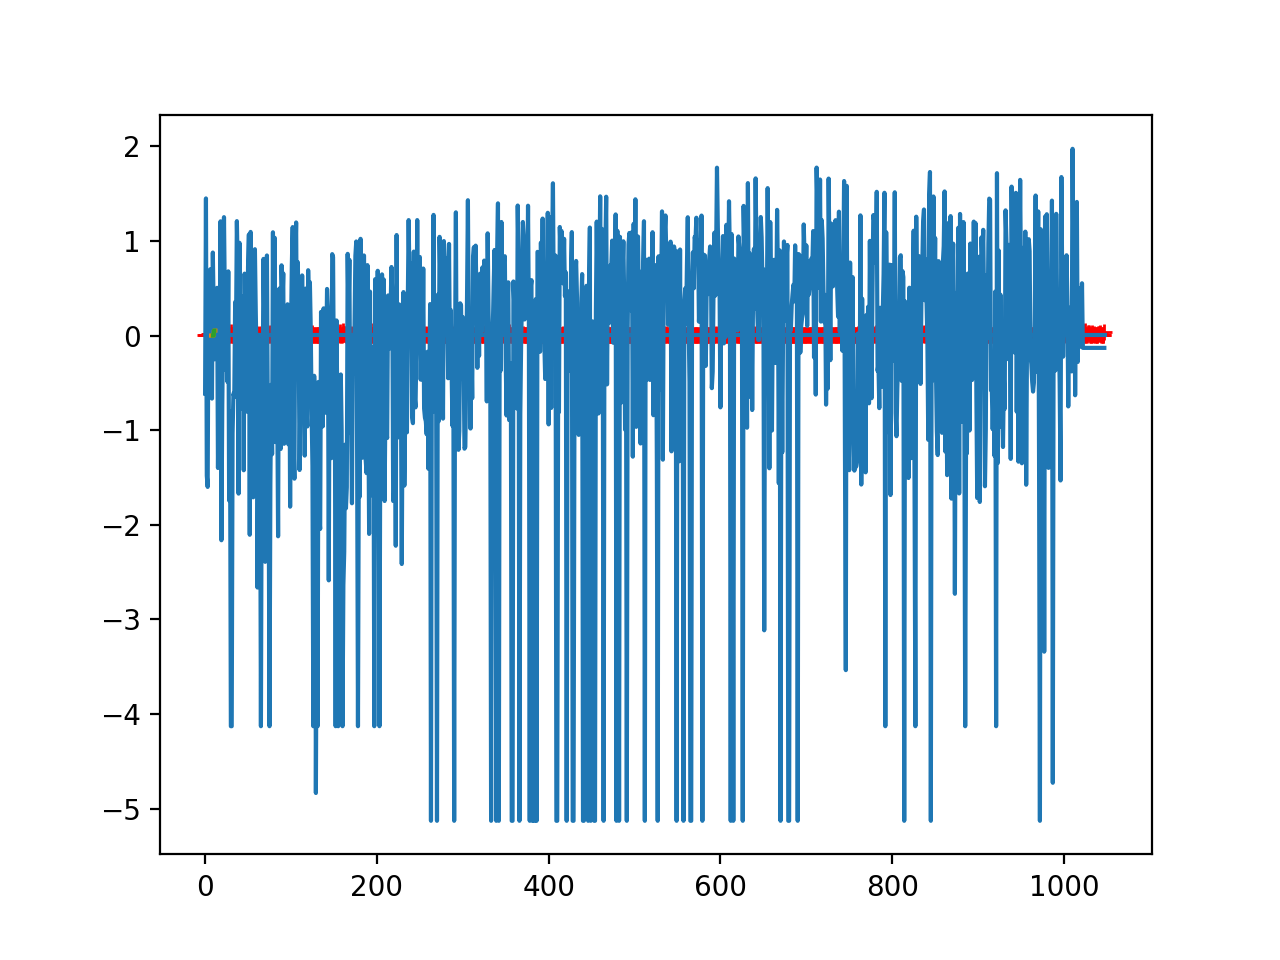

0.005

In [38]:
plt.hlines(0.0035, 0, 1050, zorder=1)
plt.plot(SNdata['biasCorErr_mu'], 'r+', zorder=0)

SNdata['biasCorErr_mu'].median()

In [77]:
def mass_step(x):
    return 0.05271/(1 + np.exp(-(x-10.13)/0.001))

<IPython.core.display.Javascript object>


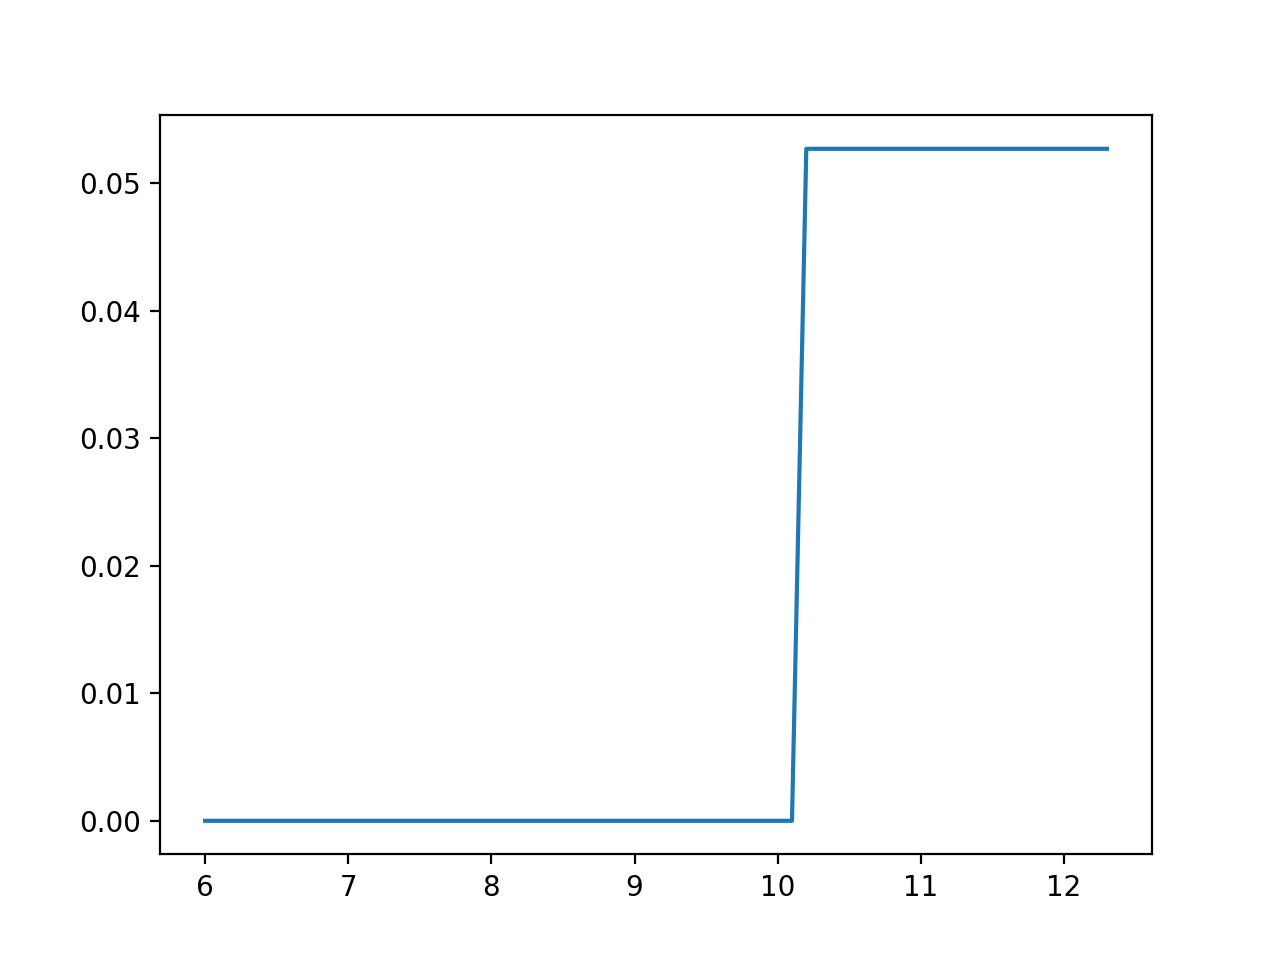

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [79]:
plt.figure()
x = np.arange(6, 12.3, 0.1)
y = mass_step(x)
plt.plot(x, y)

In [15]:
filename_G10 = '../data/Ancillary_G10.FITRES'

data = pandas.read_csv(filename_G10, comment='#', skiprows=6, header=0, delimiter=r"\s+")  

filename_outliers = '../data/FITOPT000.FITRES'
data = pandas.read_csv(filename_outliers, comment='#', skiprows=11, header=0, delimiter=r"\s+")

data.CID.duplicated().sum()
SNoutliers = data[data.duplicated(subset=['CID'], keep=False)]

SNoutliers['wt_mb'] = 1./SNoutliers['mBERR']**2
SNoutliers['wt_x1'] = 1./SNoutliers['x1ERR']**2
SNoutliers['wt_c'] = 1./SNoutliers['cERR']**2

### weighted mean

grouped = SNoutliers.groupby(['CID'], as_index=False)

def wavg_mb(group):
    d = group['mB']
    w = group['wt_mb']
    return (d * w).sum() / w.sum()

def wavg_x1(group):
    d = group['x1']
    w = group['wt_x1']
    return (d * w).sum() / w.sum()

def wavg_c(group):
    d = group['c']
    w = group['wt_c']
    return (d * w).sum() / w.sum()

def wavg_mb_er(group):
    d = group['mB']
    w = group['wt_mb']
    mean_w = (d * w).sum() / w.sum()
#     err_w = ((d - mean_w)**2 * w).sum() / w.sum()
    
#     err_w = d.mean()
    return np.sqrt(1 / w.sum())

def wavg_x1_er(group):
    d = group['x1']
    w = group['wt_x1']
    mean_w = (d * w).sum() / w.sum()
#     err_w = ((d - mean_w)**2 * w).sum() / w.sum()
#     err_w = d.mean()
    return np.sqrt(1 / w.sum())

def wavg_c_er(group):
    d = group['c']
    w = group['wt_c']
    mean_w = (d * w).sum() / w.sum()
#     err_w = ((d - mean_w)**2 * w).sum() / w.sum()
#     err_w = d.mean()
    return np.sqrt(1 / w.sum())

df_mb = grouped.apply(wavg_mb)
df_x1 = grouped.apply(wavg_x1)
df_c = grouped.apply(wavg_c)

df_mb_er = grouped.apply(wavg_mb_er)
df_x1_er = grouped.apply(wavg_x1_er)
df_c_er = grouped.apply(wavg_c_er)
print(SNoutliers['mBERR'],df_mb_er)

45     0.046508
46     0.043657
49     0.048414
51     0.033645
54     0.032205
55     0.035789
57     0.168100
66     0.039591
78     0.035003
79     0.118200
80     0.061038
84     0.040549
89     0.131200
98     0.035043
106    0.171000
112    0.037819
119    0.032793
124    0.053815
140    0.046716
164    0.034821
183    0.035833
188    0.034343
192    0.047310
193    0.026022
194    0.023922
196    0.027491
197    0.028031
200    0.033739
206    0.023906
207    0.056769
208    0.042068
209    0.041585
210    0.131200
212    0.028325
215    0.046241
217    0.156300
219    0.030405
222    0.026731
223    0.027829
226    0.028210
Name: mBERR, dtype: float64        CID       NaN
0   2004ef  0.028385
1   2005am  0.026992
2   2005eq  0.033837
3   2005hc  0.020584
4   2005iq  0.019204
5   2005ki  0.021801
6   2005lu  0.027649
7   2006ax  0.025679
8   2006et  0.019741
9   2006ev  0.051173
10  2006gj  0.034638
11  2006hb  0.029032
12  2006kf  0.092772
13  2006ob  0.022029
14   2007A  0.035

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [11]:
def mu_cov(SNdata, alpha, beta):
    # Read systematic covariance matrix 
    filecov = '../data/sys_full_long_G10.txt'
    SNcov = pandas.read_csv(filecov, comment='#', header=None)
    Ndim = int(SNcov[0][0])
    
    Cmu = np.zeros(Ndim*Ndim)
    for i in range (len(SNcov)):
        if (i>0):
            Cmu[i-1] = SNcov[0][i]
    Cmu = Cmu.reshape(Ndim,Ndim)
    
  #add diagonal term
    sig_mu2 = SNdata['mBERR']**2 + (alpha*SNdata['x1ERR'])**2 + (beta*SNdata['cERR'])**2 + 2*(alpha*SNdata['COV_x1_x0']-beta*SNdata['COV_c_x0']-alpha*beta*SNdata['COV_x1_c'])
#     sig_mass = 0.001
    sig_z = (5 * np.sqrt(0.0008**2 + SNdata['zCMBERR']**2)) / (np.log(10.) * SNdata['zCMB'])
    sig_len = 0.055*SNdata['zCMB']
    sig_int = 0.09
    sig_bias = SNdata['biasCorErr_mu']
    
    Cmu[np.diag_indices_from(Cmu)] += sig_mu2 + sig_z**2 + sig_len**2 + sig_int**2 + sig_bias**2

#     Cmu[np.diag_indices_from(Cmu)] += SNdata['MUERR']**2

           
#     Cmu[np.diag_indices_from(Cmu)] += sig_mu2 + sig_mass**2 + sig_z**2 + sig_len**2 + sig_int**2 + sig_bias**2
    return Cmu

In [12]:
# Definition of chi2 fucntion for minimization
class Chi2:

    def __init__(self, SNdata): # Construct method
        '''Attributes'''
        self.chi2tot = 0.
        self.SNdata = SNdata
        self.dL = np.zeros(shape=(len(SNdata['zCMB']))) 
    
    def chi2(self, omgM, M_b, alpha, beta, gamma):
        ''' Function that calculate the chi2 '''
        global alpha_prev
        global beta_prev
        global Cinv
        if alpha != alpha_prev or beta != beta_prev:
            alpha_prev = alpha
            beta_prev = beta
            Cinv = inv(mu_cov(self.SNdata, alpha, beta))
        mu_z = muexp(self.SNdata, M_b, alpha, beta, gamma)
        
        # Loop for matrix construction
        for i in range(len(self.SNdata['zCMB'])):
            zz = self.SNdata['zCMB'][i]
            zzz = self.SNdata['zHD'][i]
            self.dL[i] = dL_z(zz, zzz, omgM)
        
        # Contruction of the chi2 by matrix product
        result =  pylab.dot( (mu_z-self.dL), pylab.dot((Cinv), (mu_z-self.dL)))
        self.chi2tot = result
        return result

In [13]:
if __name__=='__main__':
    
    # Read Pantheon data
    filename_G10 = '../data/Ancillary_G10.FITRES'
    filename_C11 = '../data/Ancillary_C11.FITRES'
    
    data = pandas.read_csv(filename_G10, comment='#', skiprows=6, header=0, delimiter=r"\s+")  
    SNdata = outliers(data)
    
    # Global variables
    alpha_prev = alpha0
    beta_prev = beta0
    Cmat = mu_cov(SNdata, alpha0, beta0)
    Cinv = inv(Cmat)    
    
    # Perform SN fit
    ### added SNdata
    chi2function = Chi2(SNdata)
    m = Minuit(chi2function.chi2, omgM=omgM0, M_b=M_b0, alpha=alpha0, beta=beta0, gamma=gamma0,
               limit_omgM=(0.2,0.4), limit_M_b=(-20.,-18.), limit_alpha=(0.1,0.2), limit_beta=(2.,4), limit_gamma=(-0.1,0.1),
               fix_omgM=False, fix_M_b=False, fix_alpha=False, fix_beta=False, fix_gamma=False, 
               print_level=1)
    m.migrad()
    #m.hesse
    
    # Extract fitted parameters
    omgM, M_b, alpha, beta, gamma = list(m.args)
    domgM, dM_b, dalpha, dbeta, dgamma = list(np.sqrt(np.diag(m.matrix())))
#     domgM, dM_b, dalpha, dbeta, dgamma = 0, 0, 0, 0, 0
    chi2ndf = chi2function.chi2(omgM, M_b, alpha, beta, gamma) / (len(SNdata['mB'])-Npar)
    print(m.args, np.sqrt(np.diag(m.matrix())))
    print('chi2ndf = ', chi2ndf)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

14


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: InitialParamWarning: errordef is not given. Default to 1.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


------------------------------------------------------------------
| FCN = 668.6                   |     Ncalls=196 (196 total)     |
| EDM = 3.24E-09 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
<ArgsView of Minuit at 7f9f0ccf75e0>
  0.27246948677531097
  -19.193366526352484
  0.15623363681794886
  3.7548749937790773
  0.05736755537846583 [0.02481371 0.01454804 0.00684684 0.0926906  0.011

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


<IPython.core.display.Javascript object>


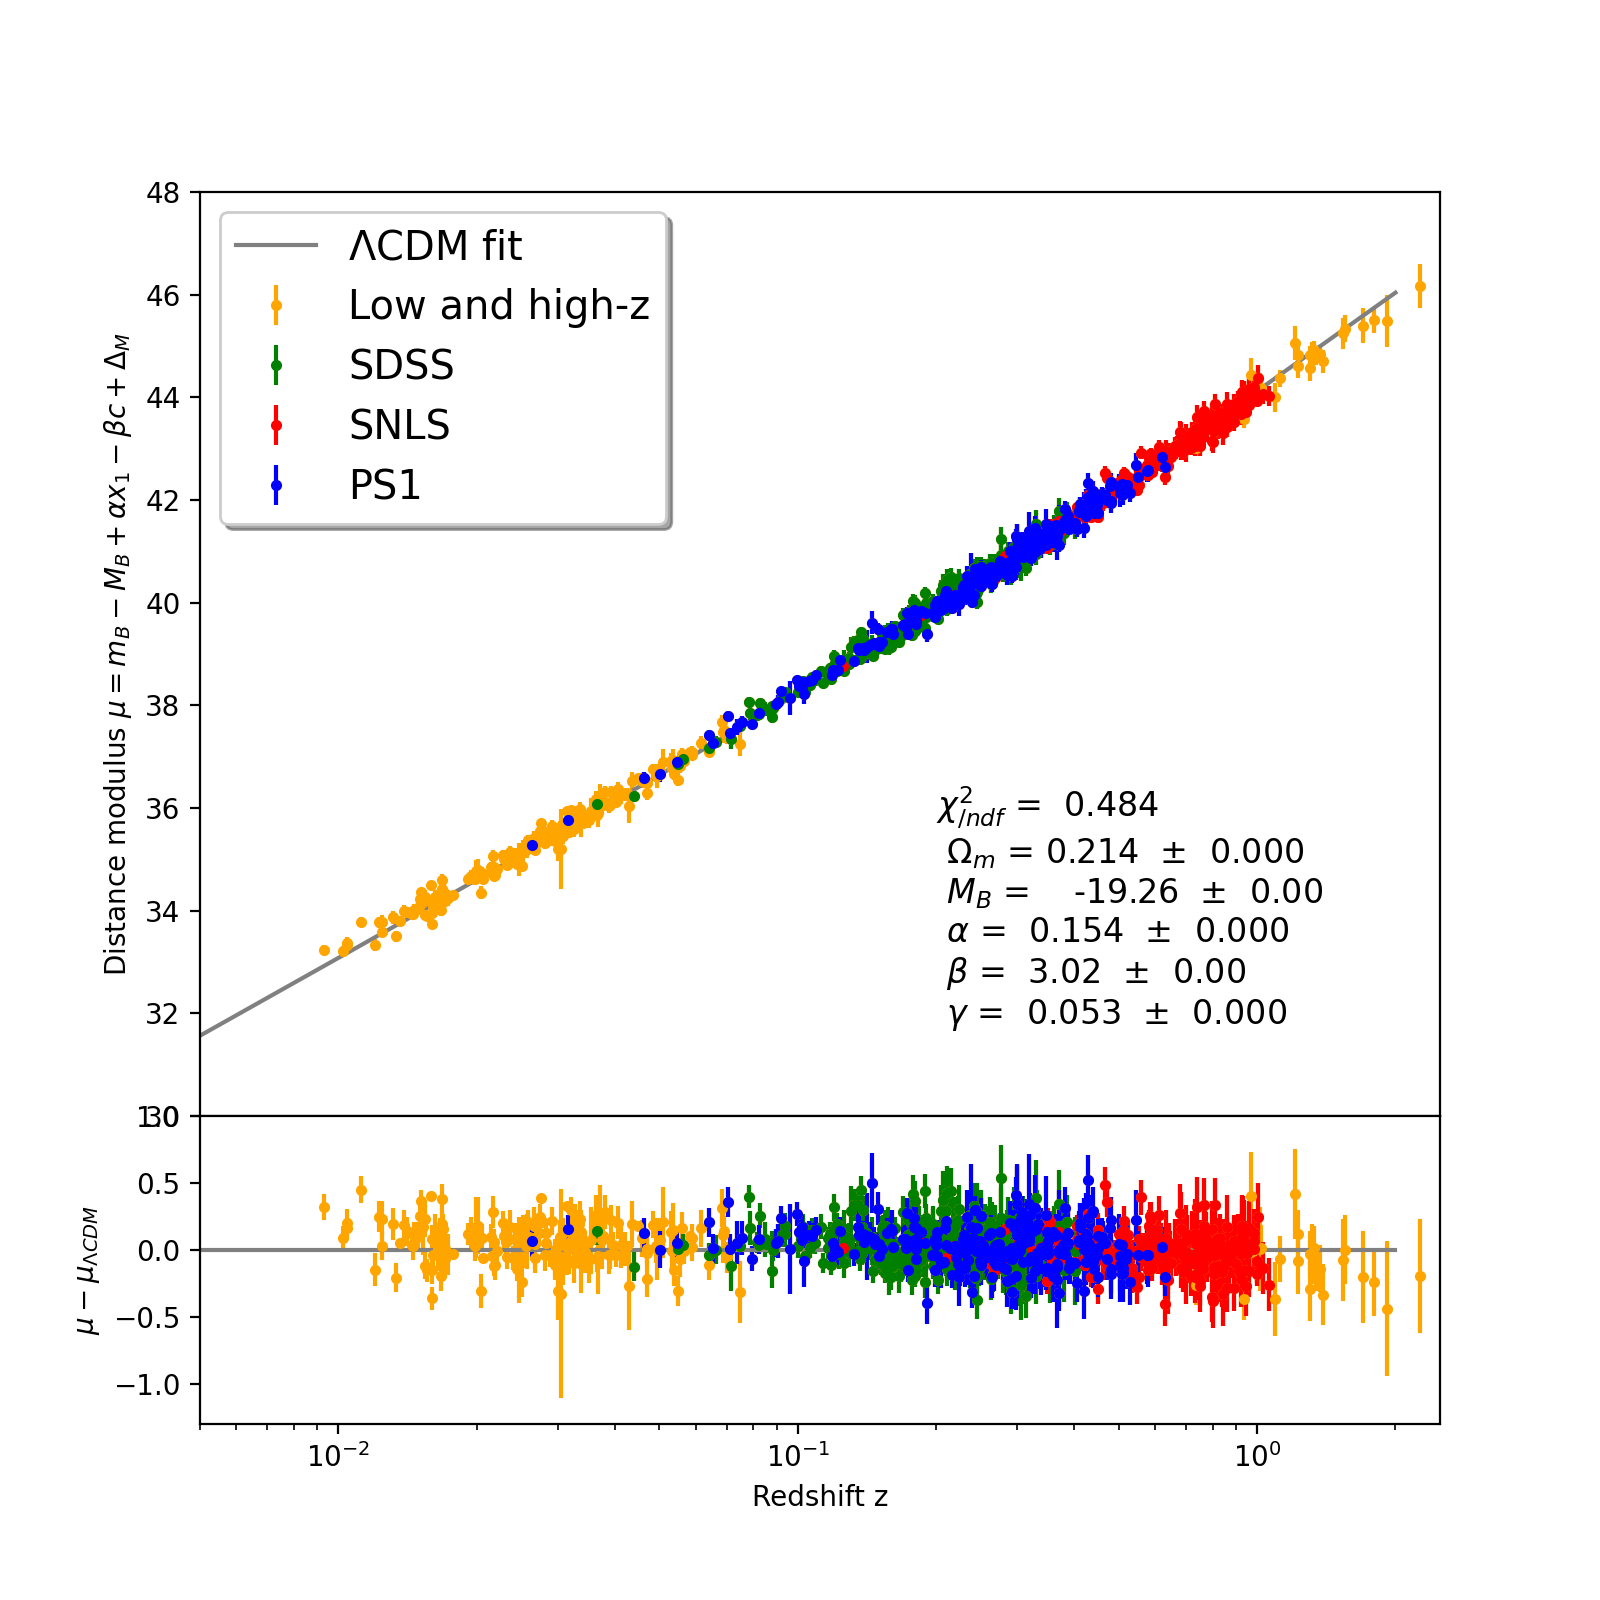

(-1.3, 1.0)

In [12]:
# Experimental distance modulus
SNdata['mu_exp'] = muexp(SNdata, M_b, alpha, beta, gamma)
mu_exp = SNdata['mu_exp']
SNdata['dmu_exp'] = dmuexp(SNdata, alpha, beta)
dmu_exp = SNdata['dmu_exp']

zcmb = SNdata['zCMB']

# Theoretical distance modulus (LambdaCDM)
SNdata['mu_th'] = fitfundL(zcmb, omgM)
mu_th = SNdata['mu_th']

# Residual = experimental - theoretical
mu_res = []
dmu_res = []
for i in range(len(mu_exp)):
    mu_res.append(mu_exp[i] - mu_th[i])
    dmu_res.append(dmu_exp[i])
SNdata['res'] = mu_res
res = SNdata['res']
SNdata['dres'] = dmu_res
dres = SNdata['dres']
    
# Theoretical curve (LambdaCDM)
xfunc = np.linspace(0.001, 2, 1000)
yfunc = np.zeros(len(xfunc))
yfunc = fitfundL(xfunc, omgM)

x0 = np.linspace(0.001, 2, 1000)
y0 = np.zeros(len(x0))
 
str0 = '{0:10s} {1:2.3f} \n'.format(r'$\chi^2_{/ndf}$ = ', chi2ndf)
str1 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\Omega_m$ =', omgM, r' $\pm$ ', domgM)
str2 = '{0:10s} {1:4.2f} {2:4s} {3:4.2f} \n'.format(r'$M_B$ = ', M_b, r' $\pm$ ', dM_b)
str3 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\alpha$ = ', alpha, r' $\pm$ ', dalpha)
str4 = '{0:10s} {1:3.2f} {2:4s} {3:3.2f} \n'.format(r'$\beta$ = ', beta, r' $\pm$ ', dbeta)
str5 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\gamma$ = ', gamma, r' $\pm$ ', dgamma)
str_fit = '{} {} {} {} {} {}'.format(str0, str1, str2, str3, str4, str5)
#print(str_fit)
####

setNBandHST = SNdata['IDSAMPLE']==0
setSDSS = SNdata['IDSAMPLE']==2
setSNLS = SNdata['IDSAMPLE']==3
setPS1 = SNdata['IDSAMPLE']==1
setHST = SNdata['IDSAMPLE']==4

fig = plt.figure(figsize=[8,8])
P1, P2 = fig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3,1]))
fig.subplots_adjust(hspace=0)
P1.errorbar(zcmb, mu_exp, yerr=dmu_exp, marker='.', color="orange", linestyle="None", 
            ecolor="orange", label='Low and high-z')
P1.errorbar(zcmb[setSDSS], mu_exp[setSDSS], yerr=dmu_exp[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green", label='SDSS')
P1.errorbar(zcmb[setSNLS], mu_exp[setSNLS], yerr=dmu_exp[setSNLS], marker='.', color="red", linestyle="None", 
            ecolor="red", label='SNLS')
P1.errorbar(zcmb[setPS1], mu_exp[setPS1], yerr=dmu_exp[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue", label='PS1')

P1.plot(xfunc, yfunc, c="grey", label="$\Lambda$CDM fit")
P1.set_xlabel('Redshift z')
P1.set_ylabel(r'Distance modulus $\mu = m_B - M_B + \alpha x_1 - \beta c + \Delta_M$')  
P1.set_xscale('log')
P1.set_xlim(5e-3, 2.3)
P1.set_ylim(30, 48)
P1.text(0.2, 31, str_fit, fontsize=12)
P1.legend(loc='best', shadow=True, fontsize='x-large')

P2.errorbar(zcmb, res, yerr=dres, marker='.', color="orange", linestyle="None", 
            ecolor="orange")
P2.errorbar(zcmb[setSDSS], res[setSDSS], yerr=dres[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green")
P2.errorbar(zcmb[setSNLS], res[setSNLS], yerr=dres[setSNLS], marker='.', color="red", linestyle="None", 
            ecolor="red")
P2.errorbar(zcmb[setPS1], res[setPS1], yerr=dres[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue")
P2.plot(x0, y0, c="grey", label="$\Lambda$CDM fit")


# P1.plot(zcmb, SNdata_G10['MU'], color="black", marker='+', linestyle="None", label='Pantheon data')
# P2.plot(zcmb, SNdata_G10['MURES'], marker='o', color="green", linestyle="None")



P2.set_xlabel('Redshift z')
P2.set_ylabel(r'$\mu - \mu_{\Lambda CDM}$')  
P2.set_xscale('log')
P2.set_xlim(5e-3, 2.5)
P2.set_ylim(-1.3, 1)

<IPython.core.display.Javascript object>


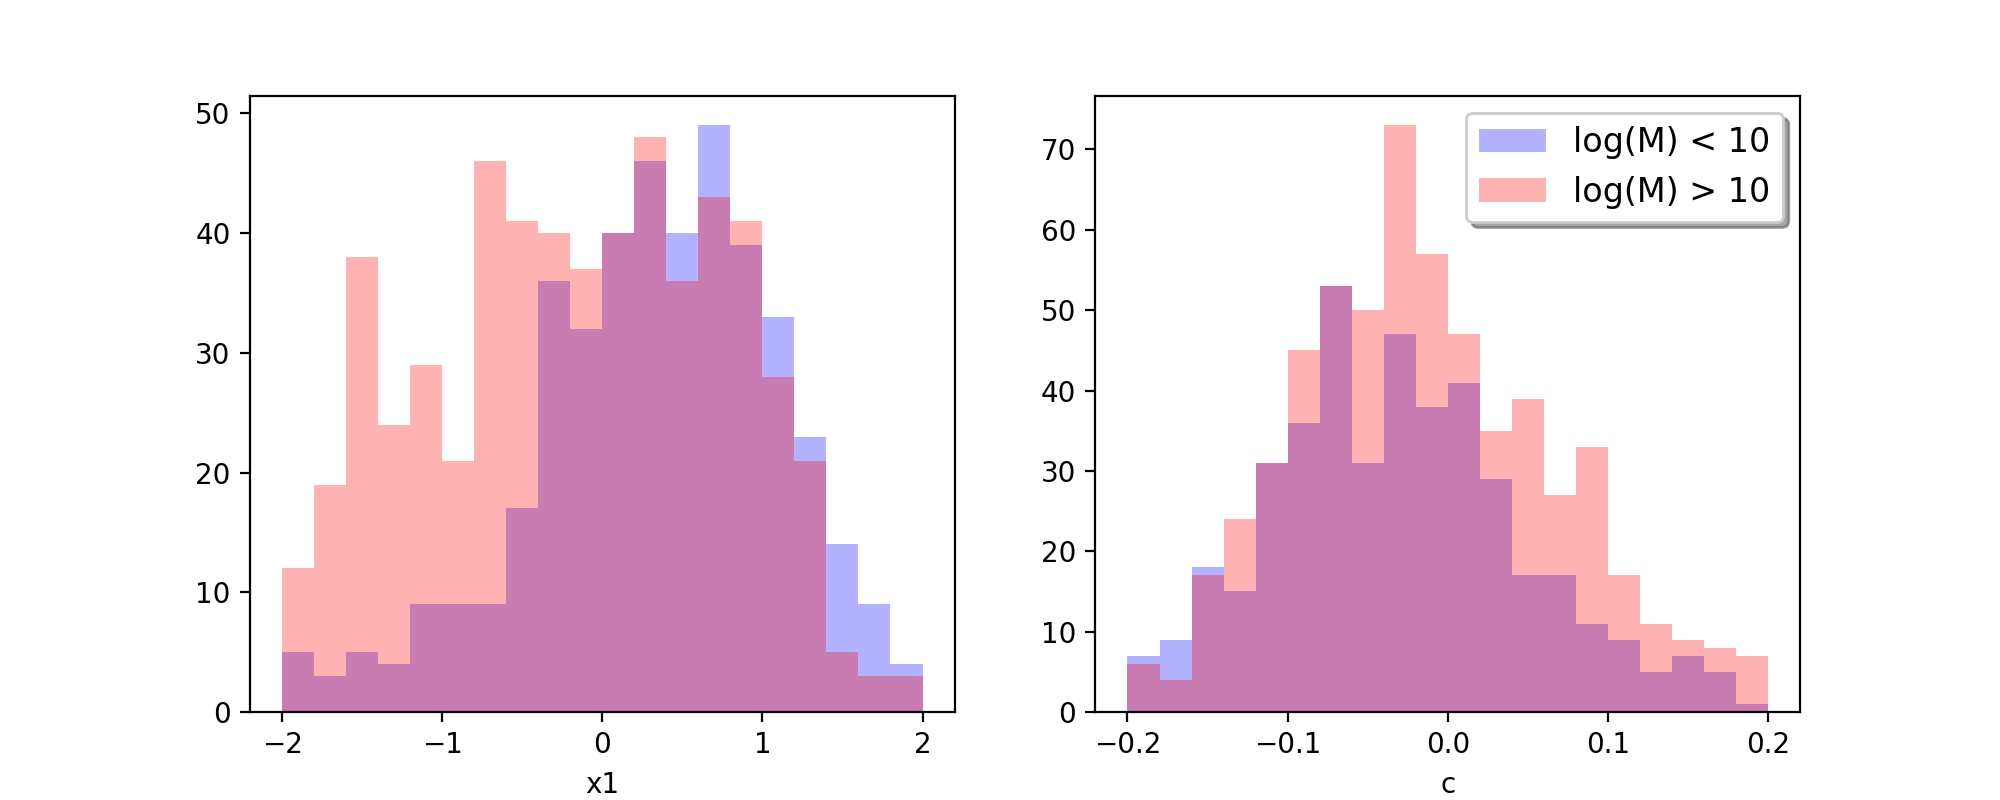

In [13]:
Mlow = SNdata['HOST_LOGMASS'] <= 10
Mhigh = SNdata['HOST_LOGMASS'] > 10

fig = plt.figure(figsize=[10,4])
ax  = fig.add_subplot(121)
ax.hist(SNdata['x1'][Mlow], 20, range=[-2,2], color='blue', alpha=0.3, label='log(M) < 10')
ax.hist(SNdata['x1'][Mhigh], 20, range=[-2,2], color='red', alpha=0.3, label='log(M) > 10')
ax.set_xlabel("x1")
ax  = fig.add_subplot(122)
ax.hist(SNdata['c'][Mlow], 20, range=[-0.2,0.2], color='blue', alpha=0.3, label='log(M) < 10')
ax.hist(SNdata['c'][Mhigh], 20, range=[-0.2,0.2], color='red', alpha=0.3, label='log(M) > 10')
ax.set_xlabel("c")
ax.legend(loc='best', shadow=True, fontsize='large')
